In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report

np.random.seed(42)

In [3]:
start_date=datetime(2016,2,19)
n_days=365*10

dates=[start_date+timedelta(days=i) for i in range(n_days)]
monthly_means=np.array([5,8,15,20,80,200,250,220,120,40,10,5]*(n_days//12+1))[:n_days]

shape=2.0
scale=monthly_means/shape
rainfall=np.random.gamma(shape,scale)

wet_prob=np.array([0.2,0.25,0.35,0.4,0.7,0.85,0.9,0.88,0.75,0.45,0.3,0.25]*(n_days//12+1))[:n_days]
rainfall=np.where(np.random.rand(n_days)<wet_prob,rainfall,0)


print(wet_prob[165:170])
print(dates[-4:])
print({monthly_means.shape})
print(monthly_means[1:2])

[0.45 0.3  0.25 0.2  0.25]
[datetime.datetime(2026, 2, 12, 0, 0), datetime.datetime(2026, 2, 13, 0, 0), datetime.datetime(2026, 2, 14, 0, 0), datetime.datetime(2026, 2, 15, 0, 0)]
{(3650,)}
[8]


In [4]:
temp_mean=25+10*np.sin(2*np.pi*np.arange(n_days)/365)

#jan=15 degrees minimum, and jul=35 degrees maximum with 10 degrees offset

temperature=np.random.normal(temp_mean,5)

# Here, a random variation of 5 degrees is added to simulate the actual conditions

humidity=40+30*np.sin(2*np.pi*np.arange(n_days)/365+np.pi/2)+np.random.normal(0,10)
humidity=np.clip(humidity,20,100)

pressure = np.random.normal(1013,5)

print(dates[265:270])
print(temp_mean[265:270])
print(humidity[265:270])

[datetime.datetime(2016, 11, 10, 0, 0), datetime.datetime(2016, 11, 11, 0, 0), datetime.datetime(2016, 11, 12, 0, 0), datetime.datetime(2016, 11, 13, 0, 0), datetime.datetime(2016, 11, 14, 0, 0)]
[15.1132241  15.08885936 15.06743151 15.04894689 15.03341098]
[30.46637417 30.97759492 31.48999813 32.00343195 32.51774426]


In [5]:
next_rainfall=np.roll(rainfall,-1)

#in the next step, fix the edge case by replacing next_rainfall[-1] with today's rainfall

next_rainfall[-1]=rainfall[-1]

#now build a DataFrame

df=pd.DataFrame({
    'date':dates,
    'rainfall_mm':rainfall,
    'temperature_c':temperature,
    'humidity_pct':humidity,
    'pressure_hpa':pressure,
    'next_day_rainfall_mm':next_rainfall
})

df['rain_tomorrow'] = (next_rainfall > 1).astype(int)

#now we have two targets, one for regression and the other for classification
#regression for predicting the next_day_rainfall_mm(65mm average)
#classification for predicting rain_tomorroe(1=yes,0=no,~52%=yes)

print(df.shape)
print(df.head)
print(df.describe())


(3650, 7)
<bound method NDFrame.head of            date  rainfall_mm  temperature_c  humidity_pct  pressure_hpa  \
0    2016-02-19     0.000000      16.491671     64.968036   1006.869263   
1    2016-02-20     0.000000      26.110681     64.963591   1006.869263   
2    2016-02-21    10.367127      31.103073     64.950258   1006.869263   
3    2016-02-22     0.000000      28.127016     64.928041   1006.869263   
4    2016-02-23   185.988576      19.490966     64.896945   1006.869263   
...         ...          ...            ...           ...           ...   
3645 2026-02-11     0.000000      30.255878     64.856981   1006.869263   
3646 2026-02-12     0.000000      24.747249     64.896945   1006.869263   
3647 2026-02-13     0.000000      25.429694     64.928041   1006.869263   
3648 2026-02-14     0.000000      23.407536     64.950258   1006.869263   
3649 2026-02-15     6.363334      27.273154     64.963591   1006.869263   

      next_day_rainfall_mm  rain_tomorrow  
0              

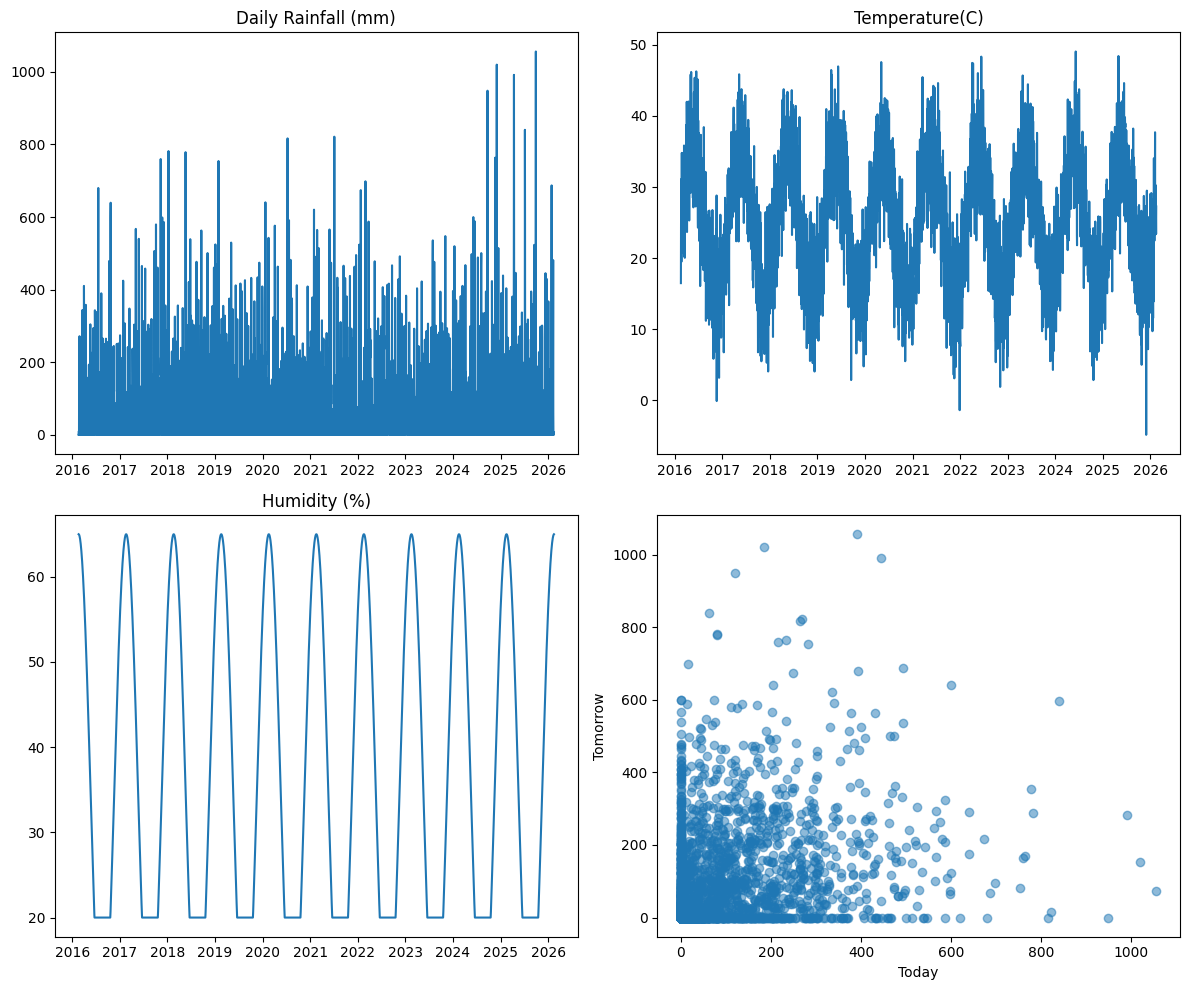

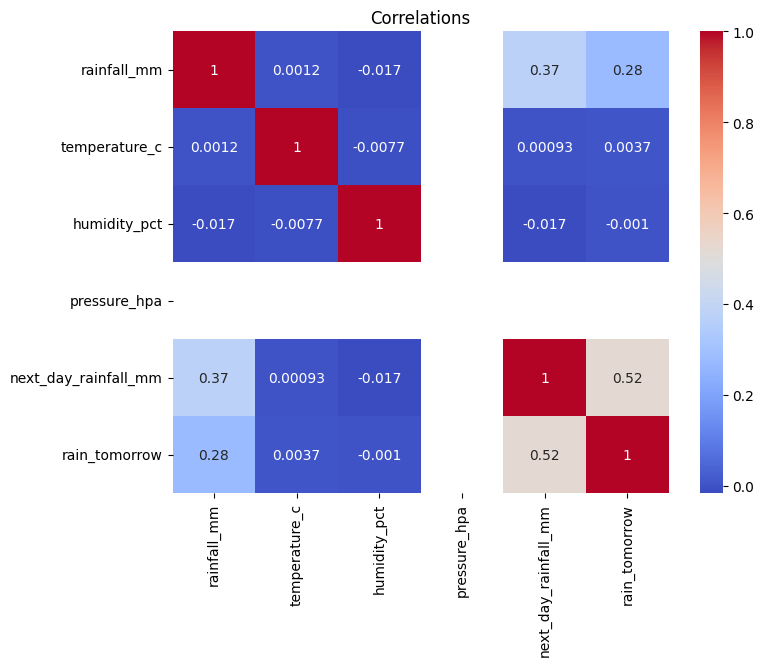

In [6]:
fig, axes=plt.subplots(2,2,figsize=(12,10))

axes[0,0].plot(df['date'],df['rainfall_mm'])
axes[0,0].set_title('Daily Rainfall (mm)')

axes[0,1].plot(df['date'],df['temperature_c'])
axes[0,1].set_title('Temperature(C)')

axes[1,0].plot(df['date'],df['humidity_pct'])
axes[1,0].set_title('Humidity (%)')

axes[1,1].scatter(df['rainfall_mm'],df['next_day_rainfall_mm'],alpha=0.5)

axes[1,1].set_xlabel('Today')
axes[1,1].set_ylabel('Tomorrow')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(df.drop('date',axis=1).corr(), annot=True,cmap='coolwarm')
plt.title('Correlations')
plt.show()

In [7]:
#train_test_split
features=['rainfall_mm','temperature_c','humidity_pct','pressure_hpa']

x_binary=df[features]
y_binary=df['rain_tomorrow']

x_train,x_test,y_train,y_test = train_test_split(x_binary,y_binary,test_size=0.2,shuffle=False)

print({x_train.shape},{x_test.shape})

{(2920, 4)} {(730, 4)}


{0.5835616438356165}
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       354
           1       0.60      0.60      0.60       376

    accuracy                           0.58       730
   macro avg       0.58      0.58      0.58       730
weighted avg       0.58      0.58      0.58       730

         feature  importance
1  temperature_c    0.481296
0    rainfall_mm    0.304604
2   humidity_pct    0.214100
3   pressure_hpa    0.000000


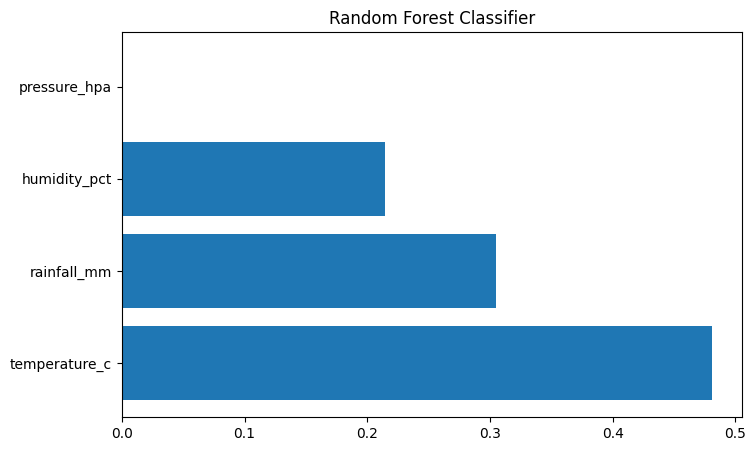

In [8]:
#randomforest model

model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

print({accuracy_score(y_test,y_pred)})
print(classification_report(y_test,y_pred))

importances = pd.DataFrame({
    'feature':features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importances)


plt.figure(figsize=(8,5))
plt.barh(importances['feature'],importances['importance'])
plt.title("Random Forest Classifier")
plt.show()

In [9]:
# Now we will predict new data, by giving entirely new data

new_weather=pd.DataFrame({
    'rainfall_mm':[750],
    'temperature_c':[41],
    'humidity_pct':[98],
    'pressure_hpa':[1010]
})

prediction = model.predict(new_weather)[0]
prob=model.predict_proba(new_weather)[0]

print({'YES' if prediction==1 else 'NO'})
print(prob[1])

{'YES'}
0.53
